# Random forest - classification

[Machine Learning Interpretability course](https://www.trainindata.com/p/machine-learning-interpretability)


In [1]:
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.tree import plot_tree
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

### Load data

In [2]:
# load titanic dataset

df = pd.read_csv('../titanic_trees.csv')

df.head()

,pclass,sibsp,parch,sex,embarked,cabin,survived
0,1,0,0,0,0,0,1
1,1,1,2,1,0,1,1
2,1,1,2,0,0,1,0
3,1,1,2,1,0,1,0
4,1,1,2,0,0,1,0


### Split data

In [3]:
# Split the data

X_train, X_test, y_train, y_test = train_test_split(
    df.drop("survived", axis=1),
    df["survived"],
    test_size=0.15,
    random_state=1,
)

X_train.shape, X_test.shape

((1112, 6), (197, 6))

### Visualize data

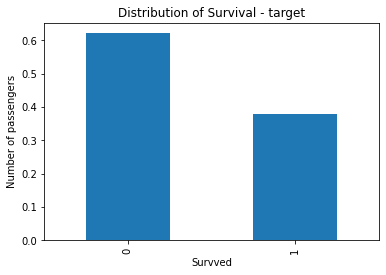

In [4]:
# Display the target distribution

y_train.value_counts(normalize=True).plot.bar()
plt.xlabel("Survved")
plt.ylabel("Number of passengers")
plt.title("Distribution of Survival - target")
plt.show()

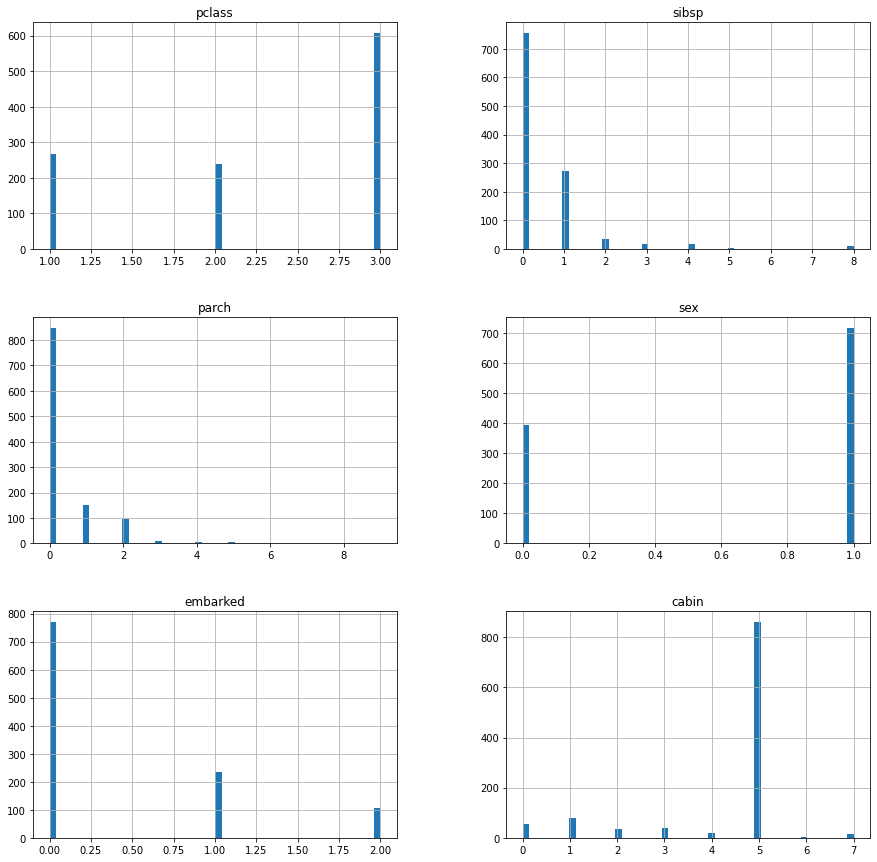

In [5]:
# Display the variables distribution

X_train.hist(bins=50, figsize=(15, 15))
plt.show()

## Random Forests

In [6]:
# fit model

rf =RandomForestClassifier(
    criterion="gini",
    n_estimators=3,
    max_depth=3,
    random_state=3,
)

rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=3, n_estimators=3, random_state=3)

In [7]:
# Accuracy in train set
rf.score(X_train, y_train)

0.7877697841726619

In [8]:
# Accuracy in test set

rf.score(X_test, y_test)

0.766497461928934

The model correctly predicts ~78% of the outcomes.

In [9]:
baseline = 1 - y_train.mean()
baseline

0.6214028776978417

A baseline model that selects the majority class (not survived) has 62% accuracy. 

Our model has 79%, which means that is better than the baseline, that is, better than just predicting the majority class.

## Plot trees in the forest

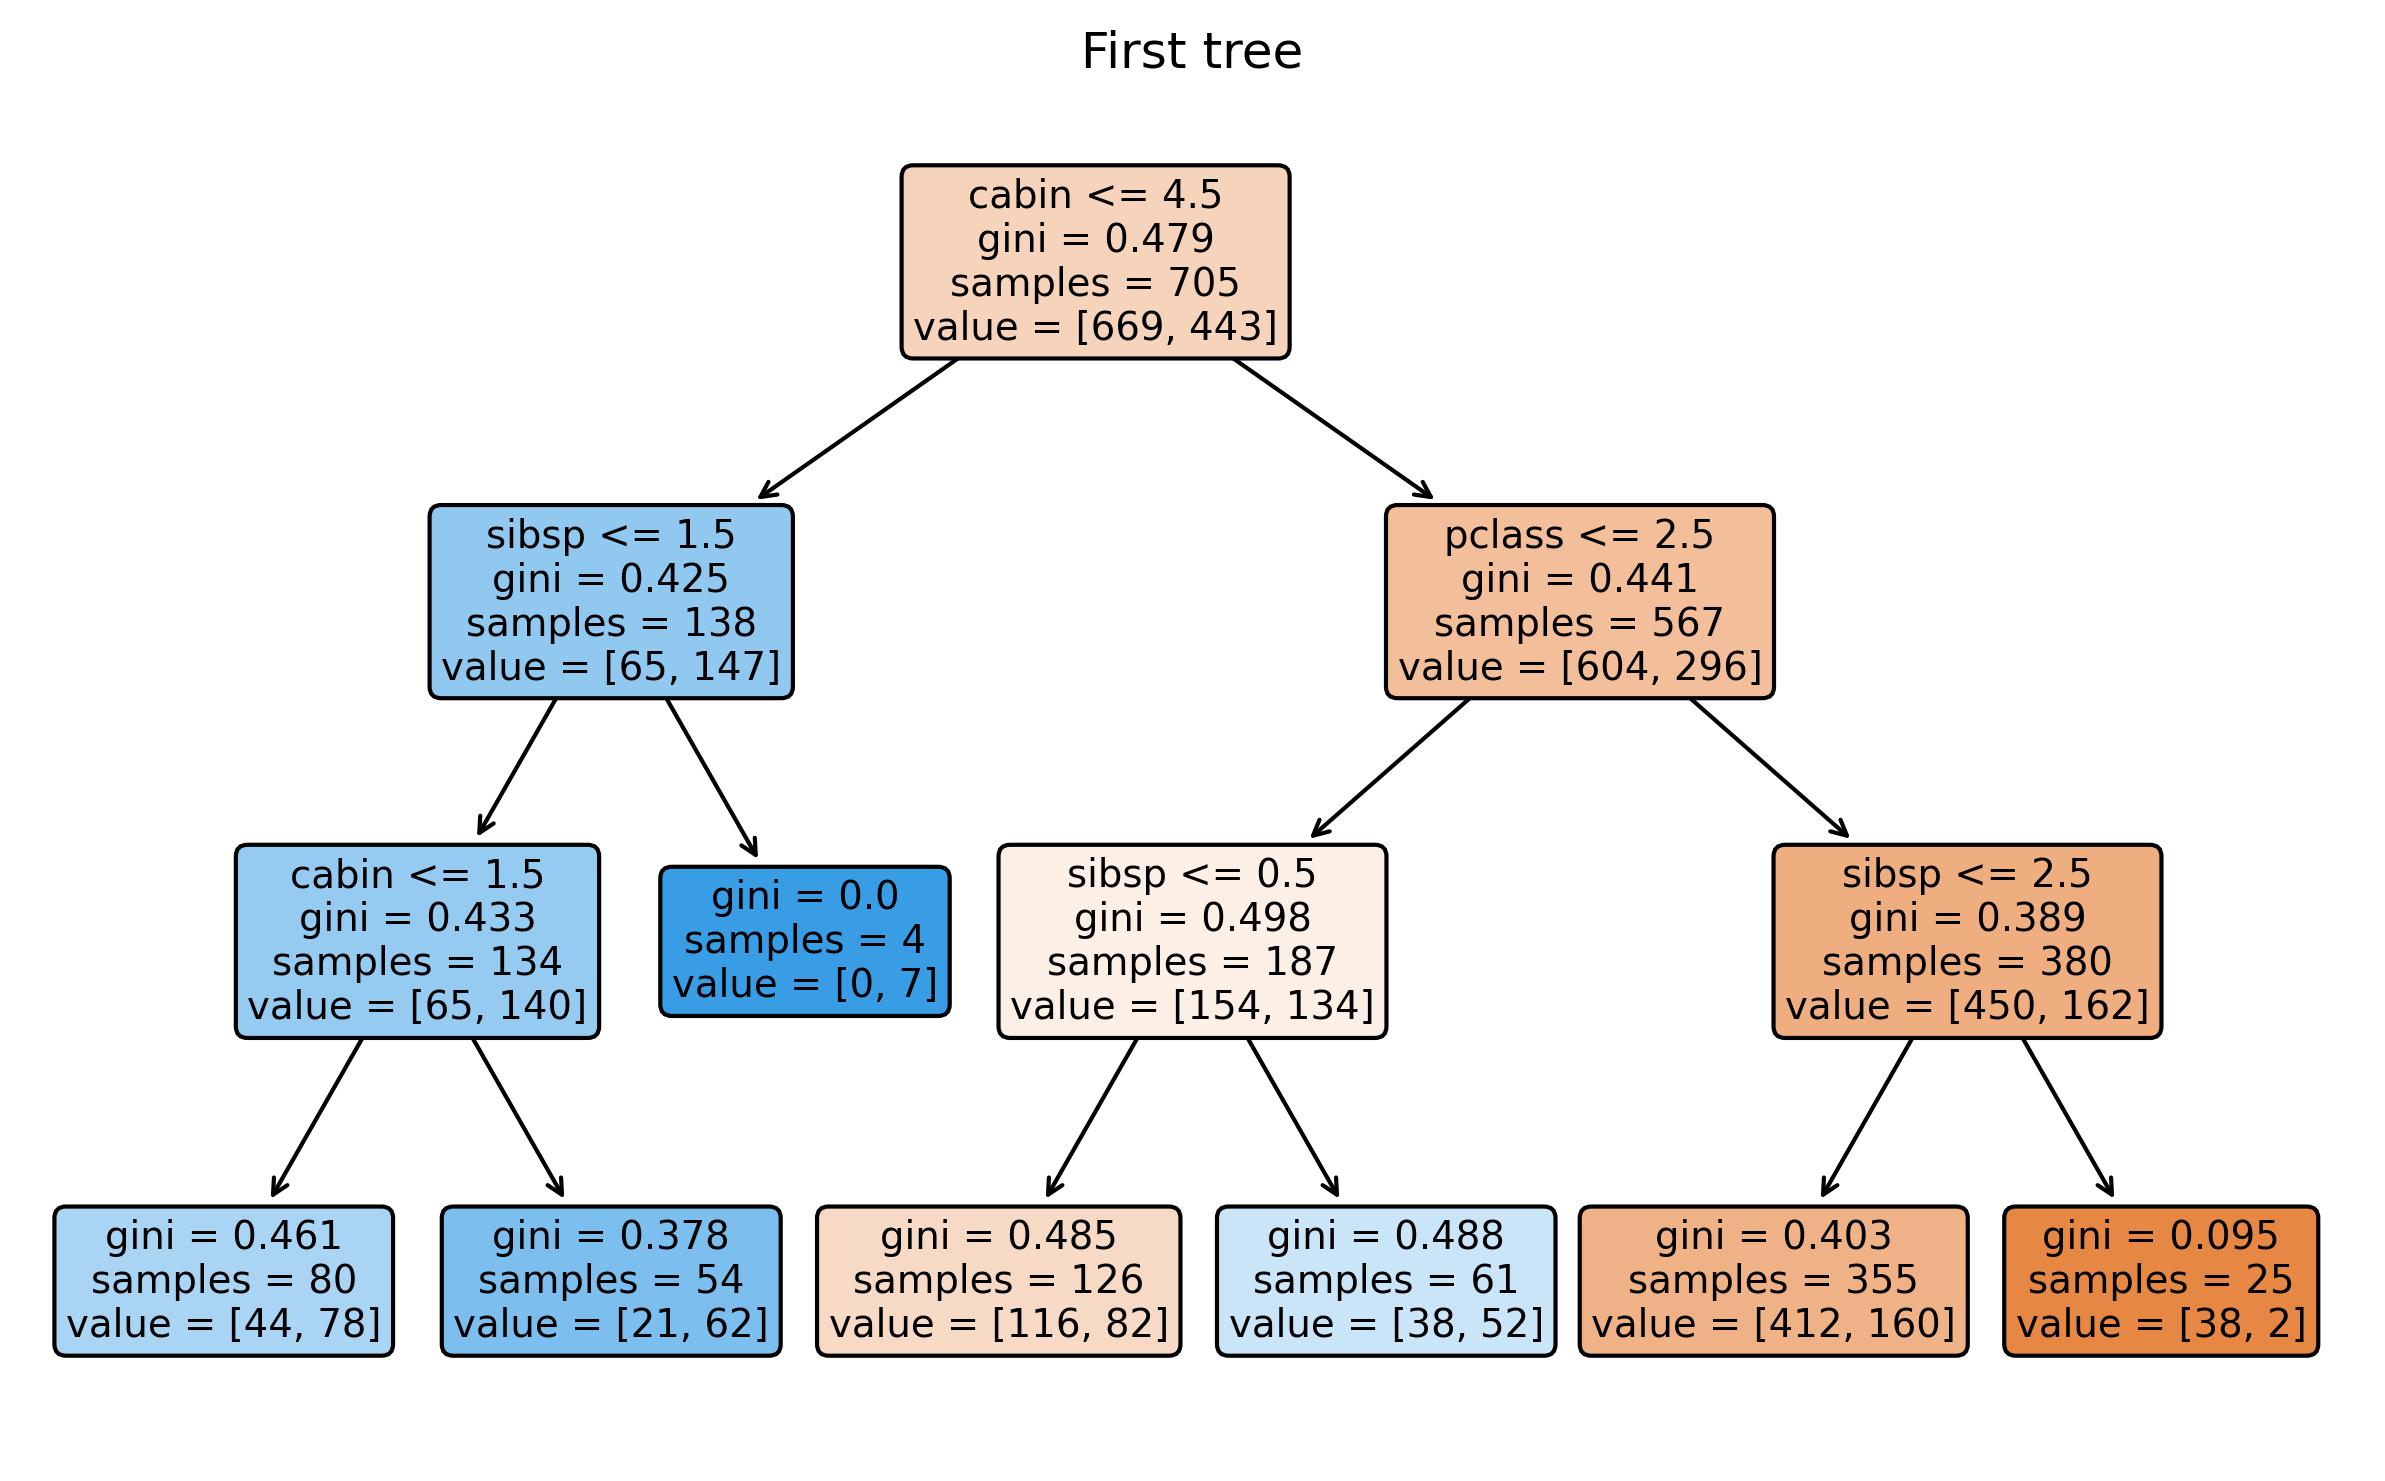

In [10]:
plt.figure(figsize=(10, 6), dpi=300)

plot_tree(
    decision_tree=rf.estimators_[0],
    feature_names=X_train.columns.to_list(),
    filled=True,  # color the squares
    rounded=True  # round squares
)
plt.title("First tree")
plt.show()

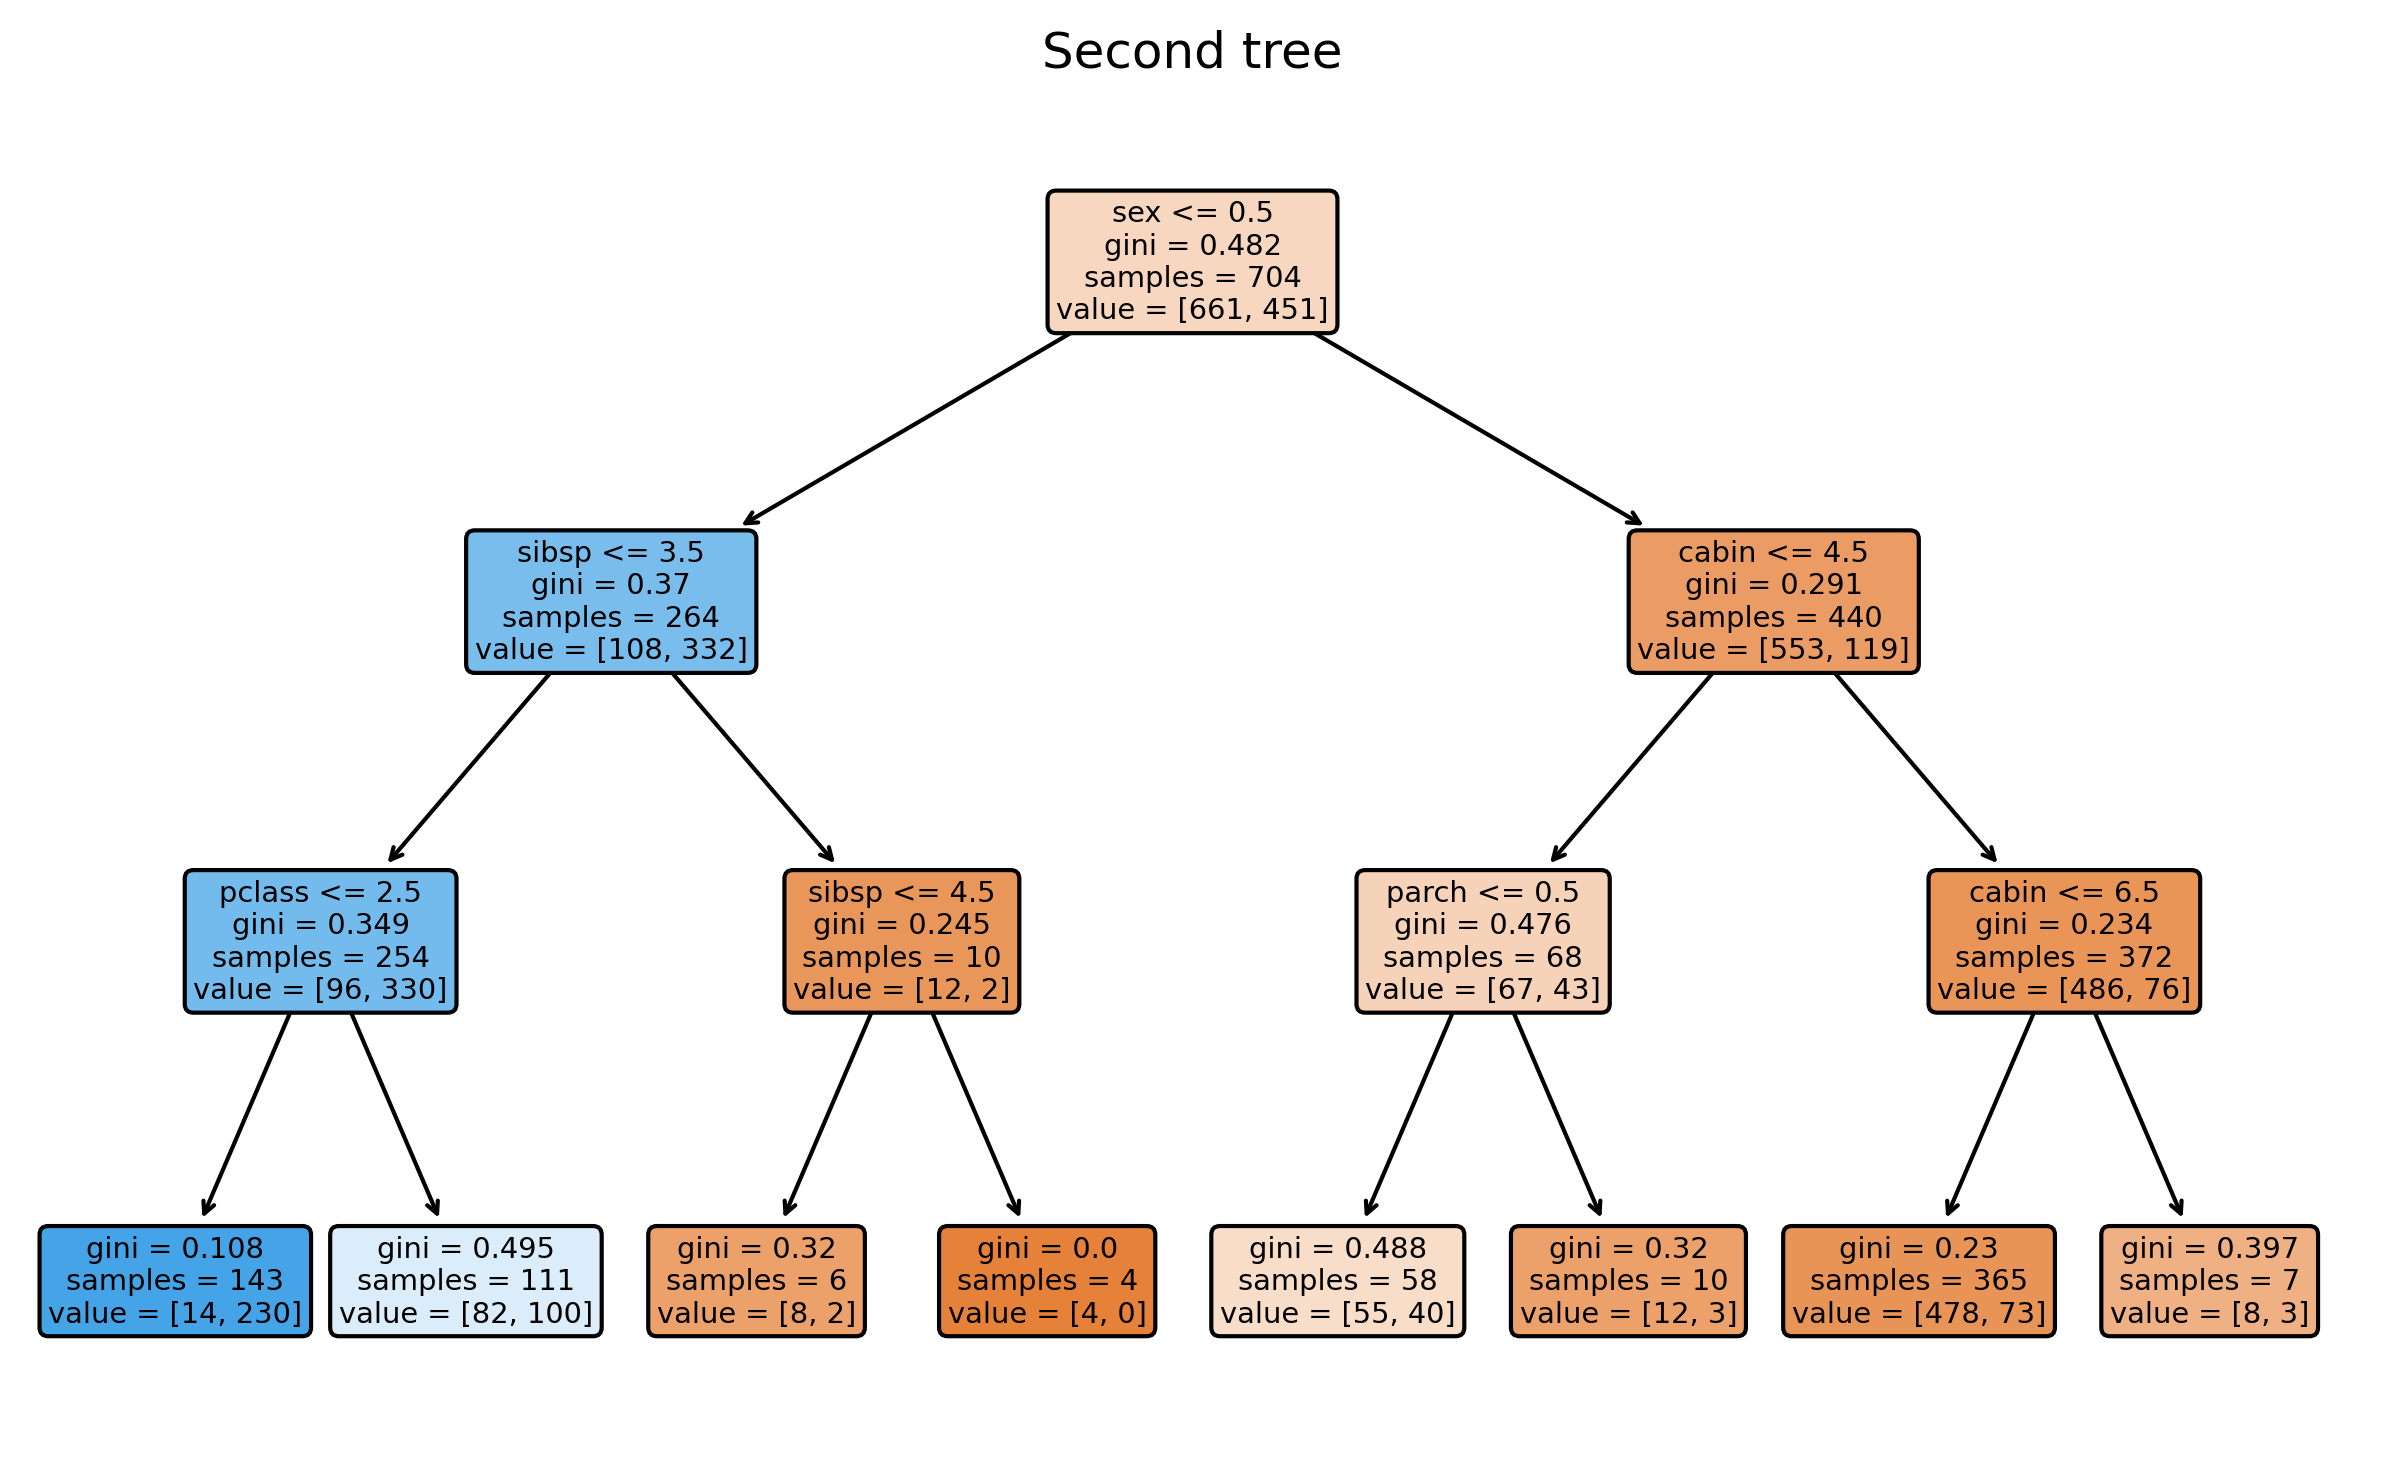

In [11]:
plt.figure(figsize=(10, 6), dpi=300)

plot_tree(
    decision_tree=rf.estimators_[1],
    feature_names=X_train.columns.to_list(),
    filled=True,  # color the squares
    rounded=True  # round squares
)
plt.title("Second tree")
plt.show()

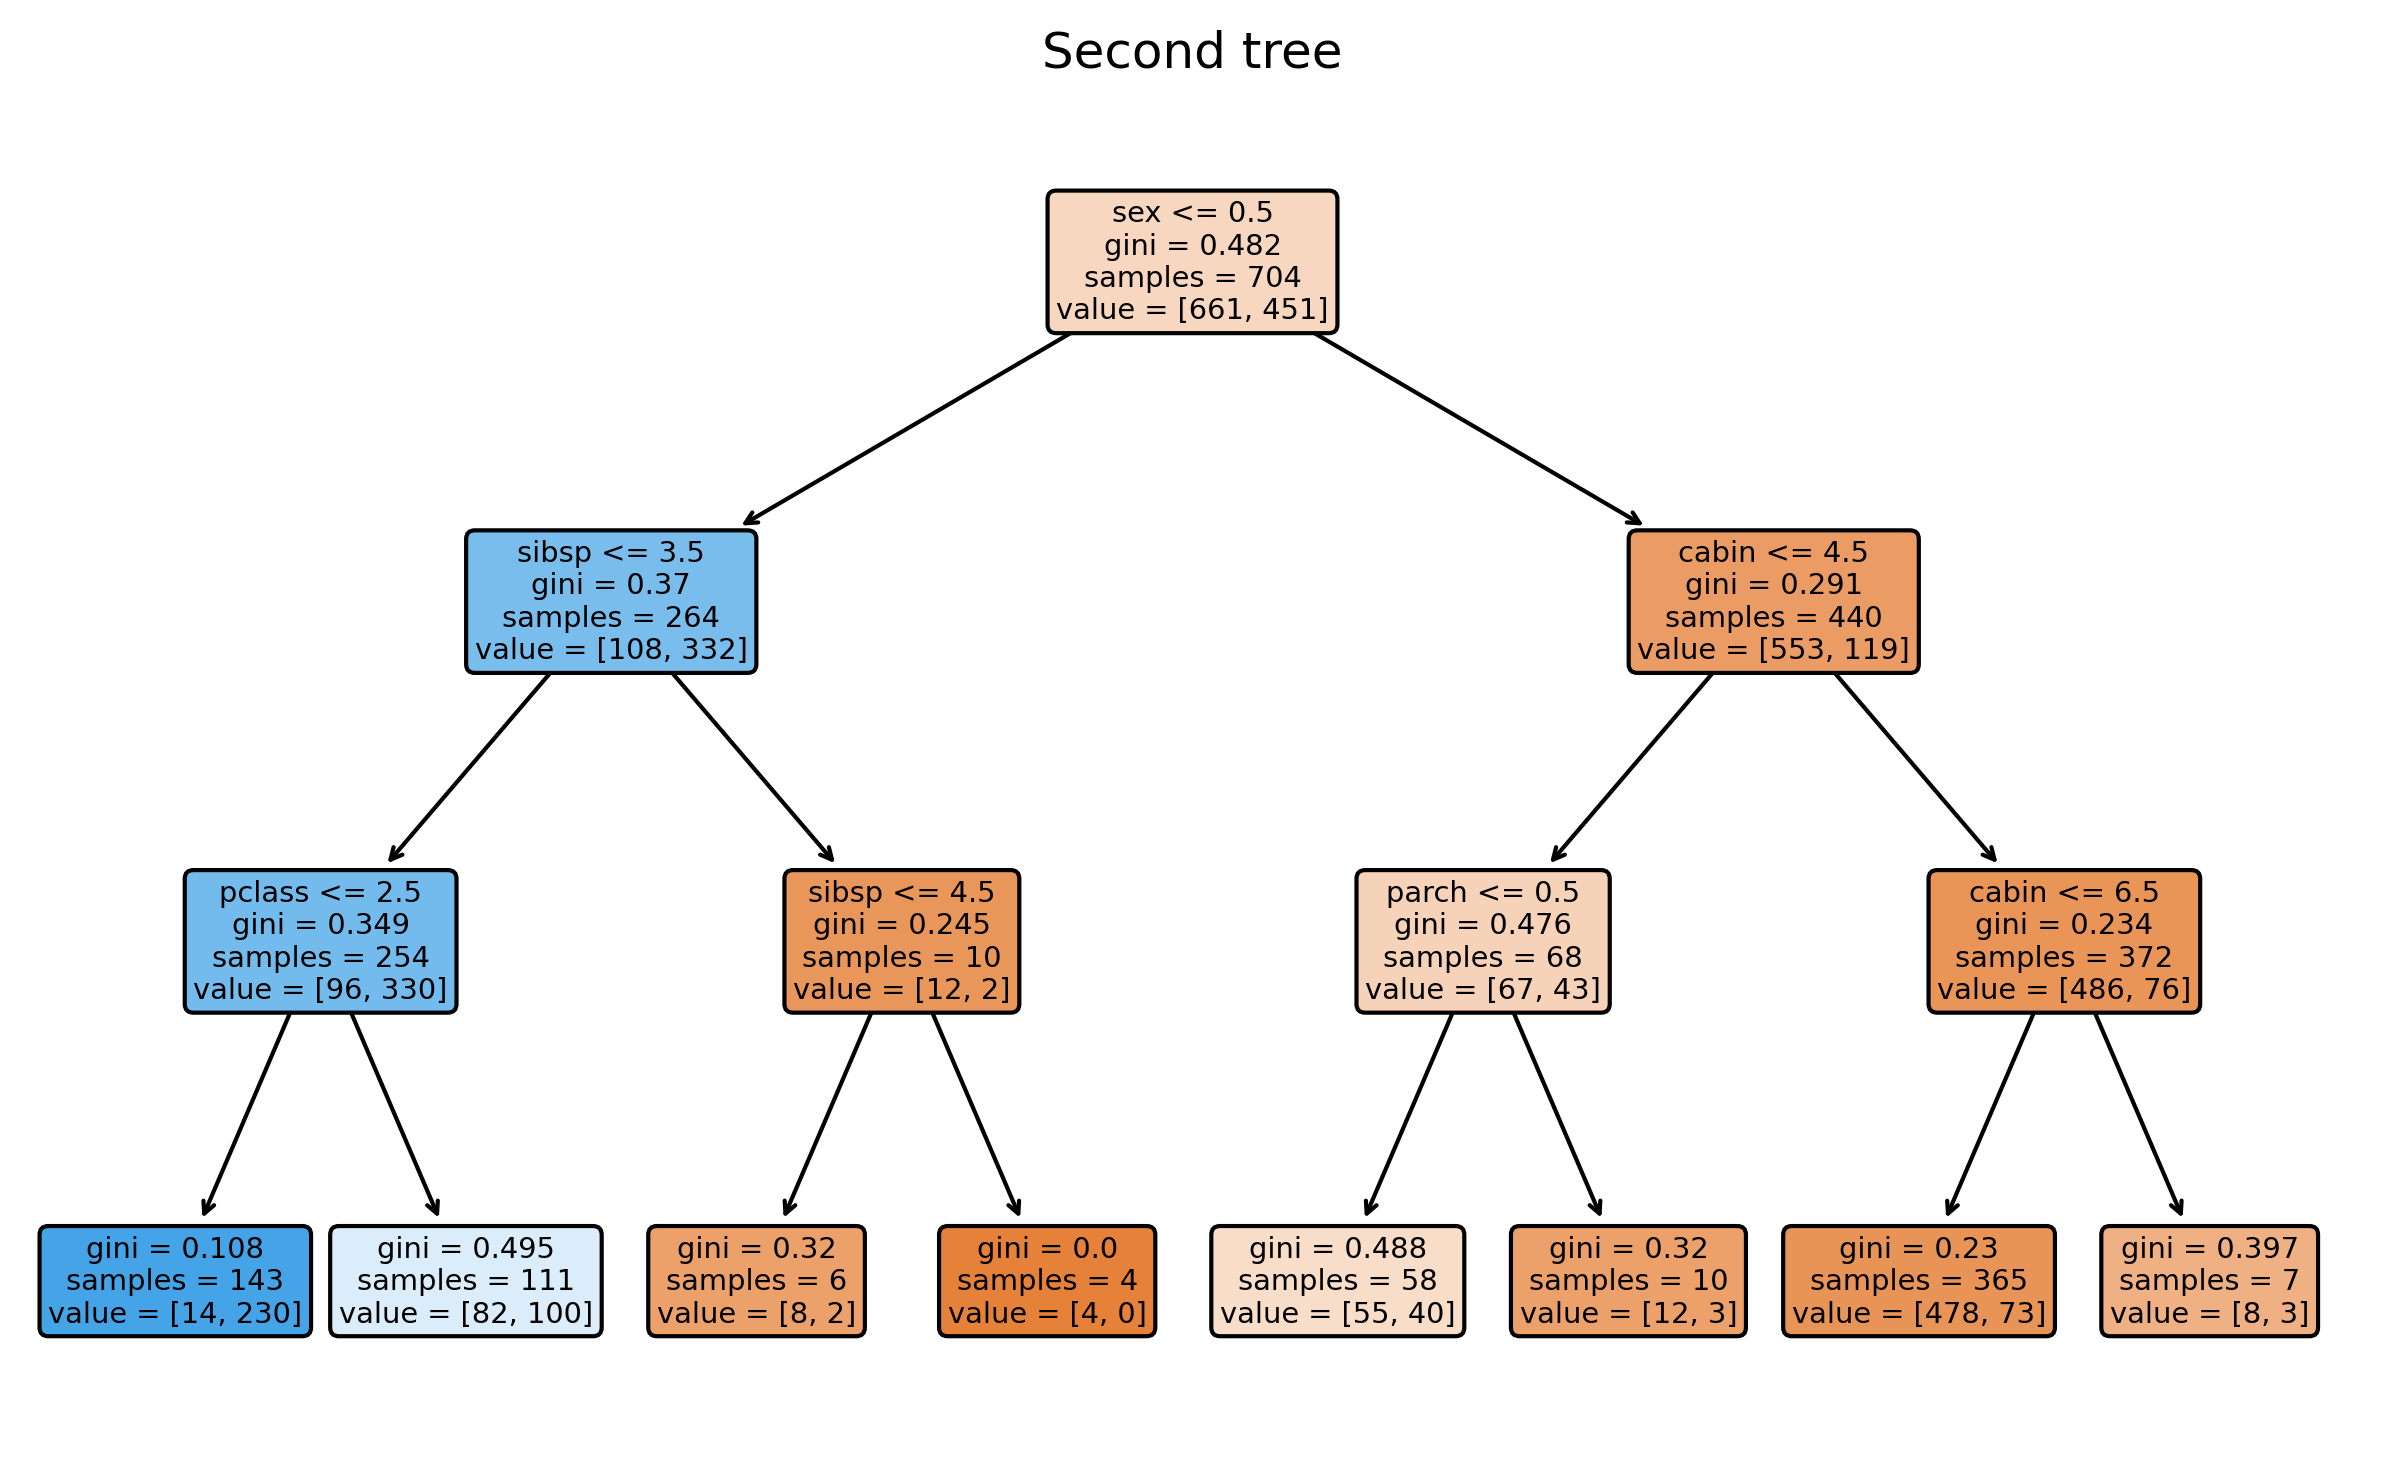

In [12]:
plt.figure(figsize=(10, 6), dpi=300)

plot_tree(
    decision_tree=rf.estimators_[1],
    feature_names=X_train.columns.to_list(),
    filled=True,  # color the squares
    rounded=True  # round squares
)
plt.title("Second tree")
plt.show()

## Global explanations - feature importance

In [13]:
# importance based on each tree

# Let's take the importance derived by each single decisiont tree

global_exp = pd.concat([
    pd.Series(rf.estimators_[0].feature_importances_),
    pd.Series(rf.estimators_[1].feature_importances_),
    pd.Series(rf.estimators_[2].feature_importances_),
], axis=1,
)

global_exp.columns = ["tree_1", "tree_2", "tree_3"]
global_exp.index = rf.feature_names_in_

global_exp["importance"] = global_exp.mean(axis=1)

global_exp

,tree_1,tree_2,tree_3,importance
pclass,0.221564,0.137536,0.226871,0.195324
sibsp,0.121215,0.047153,0.000000,0.056123
parch,0.000000,0.005403,0.026753,0.010718
sex,0.000000,0.756771,0.696740,0.484503
embarked,0.000000,0.000000,0.043634,0.014545
cabin,0.657221,0.053137,0.006003,0.238787


In [14]:
# random forest importance

global_exp = pd.Series(rf.feature_importances_, index=rf.feature_names_in_)

global_exp

pclass      0.195324
sibsp       0.056123
parch       0.010718
sex         0.484503
embarked    0.014545
cabin       0.238787
dtype: float64

As expected from the tree diagrams, gender is the most important feature, but other features help refine the estimation.

See that the mean importance that we manually calculated coincides with that of the random forest returned by sklearn.

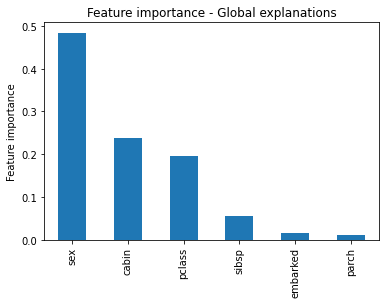

In [15]:
global_exp.sort_values(ascending=False).plot.bar()
plt.ylabel("Feature importance")
plt.title("Feature importance - Global explanations")
plt.show()

## Local explanations

The local explanation of a random forest takes the average local explanation obtained from each tree.

In [16]:
from treeinterpreter import treeinterpreter as ti

In [17]:
prediction, bias, contributions = ti.predict(rf, X_test)

C:\Users\Sole\Documents\Repositories\envs\fsml\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\Sole\Documents\Repositories\envs\fsml\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\Sole\Documents\Repositories\envs\fsml\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


In [18]:
X_test.reset_index(drop=True, inplace=True)

X_test.loc[0]

pclass      1
sibsp       0
parch       0
sex         1
embarked    0
cabin       2
Name: 0, dtype: int64

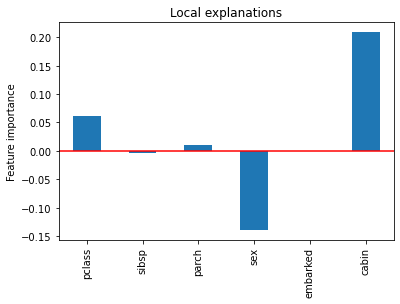

In [19]:
# First sample

pd.Series(contributions[0][:, 1], index=X_train.columns).plot.bar()
plt.axhline(y=0, color='r', linestyle='-')
plt.ylabel("Feature importance")
plt.title("Local explanations")
plt.show()

For this observations, the value of cabin and pclass increase the probability of survival, but the gender decreases the probability of survival.

In [20]:
X_test.loc[2]

pclass      1
sibsp       0
parch       0
sex         0
embarked    1
cabin       0
Name: 2, dtype: int64

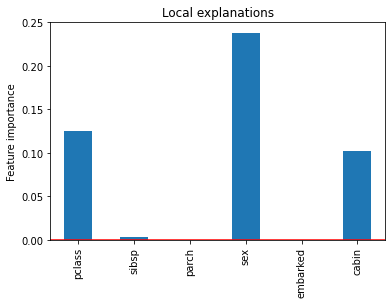

In [21]:
# Third sample

pd.Series(contributions[2][:, 1], index=X_train.columns).plot.bar()
plt.axhline(y=0, color='r', linestyle='-')
plt.ylabel("Feature importance")
plt.title("Local explanations")
plt.show()

For this observation, the values of pclass, gender and cabin, all increase the probability of survival.